In [1]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset



/Users/leakycauldron/miniconda3/envs/whisper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
"""
# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-large")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")
model.config.forced_decoder_ids = None


# load dummy dataset and read audio files
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = ds[0]["audio"]
"""

'\n# load model and processor\nprocessor = WhisperProcessor.from_pretrained("openai/whisper-large")\nmodel = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")\nmodel.config.forced_decoder_ids = None\n\n\n# load dummy dataset and read audio files\nds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")\nsample = ds[0]["audio"]\n'

In [2]:
from time import time
"""
start = time()
input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features 

# generate token ids
predicted_ids = model.generate(input_features)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=False)

transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(f"time:{time() - start}")
print(f"sample:{sample}")
print(f"transcription:{transcription}")
"""

'\nstart = time()\ninput_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features \n\n# generate token ids\npredicted_ids = model.generate(input_features)\n# decode token ids to text\ntranscription = processor.batch_decode(predicted_ids, skip_special_tokens=False)\n\ntranscription = processor.batch_decode(predicted_ids, skip_special_tokens=True)\nprint(f"time:{time() - start}")\nprint(f"sample:{sample}")\nprint(f"transcription:{transcription}")\n'

In [4]:
import argparse, logging

import transformers


import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

from ExplainableWhisper import ExplainableWhisper # # # 



/Users/leakycauldron/miniconda3/envs/whisper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = ExplainableWhisper.from_pretrained("openai/whisper-tiny") # # # model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")
model.config.forced_decoder_ids = None

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
#sample = ds[0]["audio"]

#Make spectrogram ?
#input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features 

# # # # # predicted_ids = model.generate(input_features)
#model_output = model.forward(input_features, decoder_input_ids=torch.LongTensor([[50258, 1, 2, 3]]))

#logits = model_output.logits
# transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

# print(transcription)



#load_dataset("mozilla-foundation/common_voice_13_0", "en", split="train[:1%]+validation[:1%]+test[:1%]")



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
def build_saliency_mask(saliency: torch.Tensor, r=.5, k=None):
    if k is None:
        k = int(r * saliency.numel())
    saliency_abs = saliency.abs()
    return (saliency_abs >= saliency_abs.flatten().topk(k).values.min())



def build_saliency_map(sample):
    input_features = processor(sample['audio']["array"], sampling_rate=sample['audio']["sampling_rate"], return_tensors="pt").input_features

    input_features.requires_grad = True

    sample['input_features'] = input_features

    decoder_input_ids = torch.LongTensor([processor.tokenizer(sample['text']).input_ids])

    model_output = model.forward(input_features, decoder_input_ids=decoder_input_ids)
    logits = model_output.logits[0]

    total = logits.gather(1, logits.argmax(dim=1)[None].T).sum()

    total.backward(retain_graph=True)

    return input_features.grad


def top_r_features(sample):
    saliency_map = build_saliency_map(sample)

    saliency_mask = build_saliency_mask(saliency_map)

    return sample, sample['input_features'] * saliency_mask



In [7]:
sample, output = top_r_features(ds[0])

RUNNING FORWARD PASS


In [8]:
output.shape

torch.Size([1, 80, 3000])

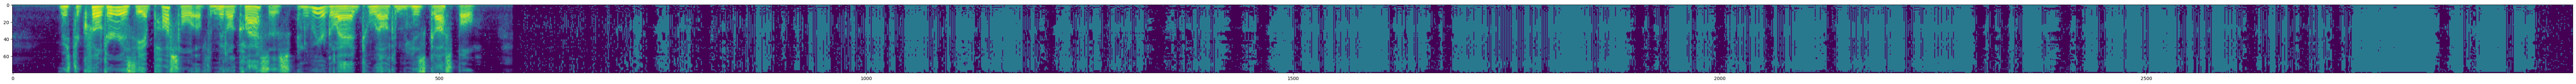

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(100, 3))
plt.imshow(output[0].detach().numpy())

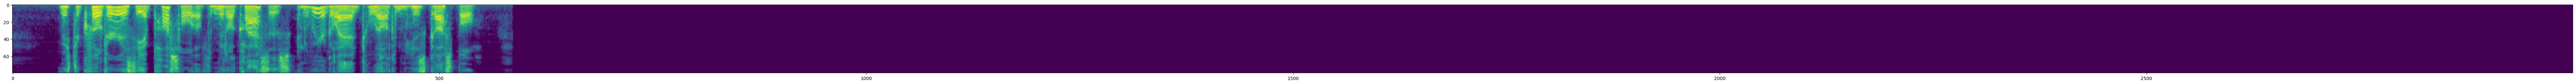

In [10]:
plt.figure(figsize=(100, 3))
plt.imshow(sample["input_features"][0].detach().numpy())

In [ ]:
plt.imshow(sample[''])